# Classifying Pneumonial Chest X-ray using a CNN

<pre>


Author           : Meijuan Xia
Project Name     : Classifying Pneumonial Chest X-ray using a CNN
                   
Description      : 1. Analysed data and classified pneumonial from Chest X-Ray images using Custom Deep Convololutional Neural Network with 5856 images 
                   2. Analysed the impact of the parameters and counts of training and validation data on performence
                   3. With Deep Convololutional Neural Network attained testing accuracy 93.47% and loss 0.20.

Dataset Link:     https://www.kaggle.com/datasets/lasaljaywardena/pneumonia-chest-x-ray-dataset

</pre>

## Introduction of the dataset



The chest X-ray images were selected from retrospective cohorts of pediatric patients aged one to five years old. All chest X-ray imaging was performed as part of the patients' routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low-quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. 

The dataset is organized into 3 folders: train, test and val. Each folder contains subfolders for each image category, namely Pneumonia and Normal. The dataset comprises 5,863 X-Ray images (JPEG format) across two categories (Pneumonia/Normal).


## Process of the training and testing result

- Load the data
- Analyse the raw data,  
- Build the models
- Train the models
- Evaluate the models
- Change the parameters and compare the performance

## Detail performance report
<pre>
------------------------------------
Loss     : 0.20  
Accuracy : 93.47%
--------------------------------------------------------------------------------
Precision    :  92.26 % 
Recall    :  98.92 % 
F1-Score    :  95.47 % 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      normal       0.97      0.81      0.88       121
   pneumonia       0.92      0.99      0.95       277

    accuracy                           0.93       398
   macro avg       0.95      0.90      0.92       398
weighted avg       0.94      0.93      0.93       398

--------------------------------------------------------------------------------
</pre>

## Import Libraries

In [292]:
import os
import numpy as np
import random
# from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

# from keras import models
from keras.models import Sequential
from keras.layers import Conv2D,  MaxPooling2D, Dropout,  Flatten, BatchNormalization, Dense

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report,ConfusionMatrixDisplay

import tensorflow as tf


import seaborn as sns

import matplotlib.pyplot as plt

import cv2

import shutil




## Define Functions

#### Data functions

In [157]:
#load the data to numpy data from dataset files and get them resized
img_size = 150


def get_img_data(data_dir):
    X_data = []
    y_data = []
    classes = removeDs(os.listdir(data_dir))

    for i in classes:
        path = os.path.join(data_dir, i)
        class_num = classes.index(i)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(
                    path, img), cv2.IMREAD_GRAYSCALE)
                resize_img = cv2.resize(img_arr, (img_size, img_size))
                X_data.append(resize_img)
                y_data.append(class_num)
            except Exception as e:
                print(e)
    return np.array(X_data), np.array(y_data)


In [158]:
# Normailizing
def trans_input_data(data, img_size):
    data_norm = np.array(data)/255
    data_input = data_norm.reshape(-1, img_size, img_size, 1)
    return data_input


In [159]:
# Remove '.DS_Store' file from directory in Mac
def removeDs(dir_ori):
    for i in dir_ori:
        if i == '.DS_Store':
            dir_ori.remove(i)
    dir_new = dir_ori
    return dir_new


In [178]:
def files_count(dir):
    file_count=0
    for r,d,f in os.walk(dir):
        file_count= file_count + len(f)
    return file_count


In [8]:
# Get all the files from directory
def sub_dir_files(main_dir):
    sub_dir = os.listdir(main_dir)
    # sub_dir_counts = len(sub_dir)
    sub_dir = removeDs(sub_dir)
    sub_dir_names = []
    sub_dir_files_counts = []

    for i in sub_dir:

        cur_dir = main_dir + '/' + i
        files_counts = len(os.listdir(cur_dir))
        sub_dir_names.append(i)
        sub_dir_files_counts.append(files_counts)
    return sub_dir_names, sub_dir_files_counts


In [9]:
#show the counts of samples in every dataset
def counts_in_dataset(input_dir):
    main_dir_list = removeDs(os.listdir(input_dir))
    for dir in main_dir_list:
        sub_dir_names,sub_dir_file_counts= sub_dir_files(input_dir + '/' +dir)
        for i in range(len(sub_dir_names)):
            print('Count of %s in %s dataset is: %d '%(sub_dir_names[i],dir,sub_dir_file_counts[i]))

#### Data visualization functions

In [81]:
def select_image_samples(dir, samples_counts):
    classes = removeDs(os.listdir(dir))
    class_count = len(classes)

    image_files_paths = {}

    for i in range(class_count):
        sub_dir_path = dir + '/' + classes[i]
        sub_dir_files = os.listdir(sub_dir_path)
        sub_dir_files_counts = len(sub_dir_files)
        image_files_paths[classes[i]] = []
        file_indexs = random.sample(range(sub_dir_files_counts), samples_counts)
        #print(len(file_indexs),len(np.unique(file_indexs)))
        for j in file_indexs:
            file_name = sub_dir_files[j]
            file_path = sub_dir_path+'/'+file_name
            image_files_paths[classes[i]].append(file_path)
    return image_files_paths


In [321]:
def plot_params(fig_size=(16, 6), title='', xlabel='', ylabel='', legends=[], title_fontsize=16, label_fontsize=14, image_file_name="", save=False, dpi=100, update_image=True):
    plot_params = {}
    plot_params['figsize'] = fig_size
    plot_params['title'] = title
    plot_params['xlabel'] = xlabel
    plot_params['ylabel'] = ylabel
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
 #   plot_params["label_fontsize"] = label_fontsize

    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image

    plot_params["subplot"] = None
    return plot_params


In [11]:
def plot_images(image_files_paths, count_per_class, update_image=True):
    # fig,axs = plt.subplots(nrows=1,ncols = count_per_class,subplot_kw={'xticks': [], 'yticks': []})
    i = 0
    plt.figure(figsize=(10, 3))
    plt.rcParams.update({'axes.titlesize': 'small'})
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    for file_path in image_files_paths:

        plt.subplot(1, count_per_class, i+1)
        img = cv2.imread(file_path, 1)
        # plt.figure(figsize=(3,3),dpi=100,facecolor='w')
        plt.title(file_path.split('/')[-1])

        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        i = i+1

    plt.tight_layout()
    plt.show()


In [155]:
def count_barplot(dir, title, xlabel, ylabel, figsize=(10, 8), title_fontsize=12, label_fontsize=12, sub_no=0):
    sub_dir_names, sub_dir_files_counts = sub_dir_files(dir)
    x = sub_dir_names
    y = sub_dir_files_counts
    font_title = {'family': 'Times New Roman',
                  'weight': 'normal', 'size': title_fontsize}
    font_label = {'family': 'Times New Roman',
                  'weight': 'normal', 'size': label_fontsize}

    plt.subplot(sub_no)
    sns.barplot(x=x, y=y)
    # plt.text
    plt.title(title, fontdict=font_title)
    plt.xlabel(xlabel, fontdict=font_label)
    plt.ylabel(ylabel, fontdict=font_label)
    plt.xticks(range(len(x)), x)


In [154]:
def dataset_counts_barplot(dir):
    sub_dirs = removeDs(os.listdir(dir))
    xlabel = 'Type'
    ylabel = 'Counts'
    fig_size = (10, 3)
    title_fontsize = 12
    label_fontsize = 12
    title = 'Number of Cases in '+dir

    plt.figure(figsize=fig_size)
    i=131
    for sub_dir in sub_dirs:
        count_barplot(dir +'/'+ sub_dir, title=title+'('+sub_dir+')', xlabel=xlabel,
              ylabel=ylabel, label_fontsize=label_fontsize, sub_no=(i))
        i+=1
    plt.show()


In [153]:
def selected_image_show(img_dir, class_count, count_per_class):
    #img_file_paths = {}
    selected_img = select_image_samples(img_dir, count_per_class)
    for class_name in selected_img:
        print('-'*50, class_name.upper(), '-'*50)
        plot_images(selected_img[class_name], count_per_class)
        print('')
    print("%s%s%d%s" % ("-"*55, "All Class Printed:", class_count, "-"*55))


In [152]:
def plot_history(history):
    plt.figure(figsize=(10,5),facecolor='w')

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'],label= 'TraingingLoss')
    plt.plot(history.history['val_loss'],label='ValidationLoss')
    plt.title('Traing and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()   

In [151]:
def show_correct_img(pred_y_test,X_test,y_test):
    correct = np.nonzero(pred_y_test==y_test)[0]
    i =0
    plt.figure(figsize=(8,8))
    for c in correct:
        plt.subplot(4,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(X_test[c],cmap='gray',interpolation='none')
        plt.title('Predict:{}\nActual:{}'.format(classes[pred_y_test[c]],classes[y_test[c]]),fontdict={'color':'green'})
   
        i+=1

def show_fel_img(pred_y_test,X_test,y_test):
    fel = np.nonzero(pred_y_test!=y_test)[0]
    i =0
    plt.figure(figsize=(8,8))
    for f in fel:
        plt.subplot(3,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(X_test[f],cmap='gray',interpolation='none')
        plt.title('Predict:{}\nActual:{}'.format(classes[pred_y_test[f]],classes[y_test[f]]),fontdict={'color':'red'})
        i+=1

#### Model-building Functions

In [149]:
# create CNN model
def get_base_model():
    model = Sequential()
    #first
    model.add(Conv2D(32, (3, 3), strides=1, padding='same',
          activation='relu', input_shape=(150, 150, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    #second
    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

    #third
    model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=2, padding='same'))

   #FC layer
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=64,activation='relu'))
    model.add(Dropout(0,2))

    #output layer
    model.add(Dense(units=1, activation='sigmoid'))

    print(model.summary())
    return model


In [148]:
#create CNN with en extra convolution layer
def get_base_model_morelayers():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=1, padding='same',
          activation='relu', input_shape=(150, 150, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

    model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=2, padding='same'))

    model.add(Conv2D(256,(3,3),strides=1,padding='same',activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=64,activation='relu'))
    model.add(Dropout(0,2))

    model.add(Dense(units=1, activation='sigmoid'))

    print(model.summary())
    return model


In [ ]:
# 

# def fit_model_gen(model,epochs,callbacks,optimizer,train_data_gen,validation_data_gen,loss,batch_size):
#     model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
#     history = model.fit(train_data_gen,batch_size=batch_size,epochs=epochs,validation_data=validation_data_gen,callbacks=callbacks)
#     return history

In [147]:
# compile and fit the model with training data and test data
def fit_model(model,epochs,callbacks,batch_size):
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(datagen.flow(X_train,y_train,batch_size=batch_size),
                        epochs=epochs,validation_data=datagen.flow(X_test,y_test,batch_size=batch_size),callbacks=callbacks)
    return history

In [170]:

def fit_model_adam(model,epochs,callbacks,batch_size):
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(datagen.flow(X_train,y_train,batch_size=batch_size),
                        epochs=epochs,validation_data=datagen.flow(X_test,y_test,batch_size=batch_size),callbacks=callbacks)
    return history

In [190]:
# compile and fit the model with training data and validation data
def fit_model_val(model,epochs,callbacks,batch_size):
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(datagen.flow(X_train,y_train,batch_size=batch_size),
                        epochs=epochs,validation_data=datagen.flow(X_val,y_val,batch_size=batch_size),callbacks=callbacks)
    return history

In [150]:
# predict the test data
def show_predictions(model,X_test,y_test):
    results = model.evaluate(X_test,y_test)
    print("%s%.2f  "% ("Loss     : ", results[0]))
    print("%s%.2f%s"% ("Accuracy : ", results[1]*100, "%"))   
    print('*'*50)
    print('Confusion_Matrix:')
    predictions=model.predict(X_test)
    predictions= predictions.reshape(1,-1)[0]
    pred_y_test=np.around(predictions).astype(int)
    cm = confusion_matrix(y_test,pred_y_test)
    print(cm)
    return pred_y_test

## Data-Preprocessing

In [129]:
#load the data from folders
input_dir = r'archive/'
adjust_dir = r'adjust'

train_dir = input_dir+r'train'
validation_dir = input_dir+r'val'
test_dir = input_dir + r'test'


### Take a look at the dataset

In [130]:
names, counts = sub_dir_files(train_dir)
print(names, counts)

['pneumonia', 'normal'] [3875, 1341]


In [132]:
# show numbers of samples in datasets
counts_in_dataset(input_dir)

Count of pneumonia in test dataset is: 390 
Count of normal in test dataset is: 234 
Count of pneumonia in train dataset is: 3875 
Count of normal in train dataset is: 1341 
Count of pneumonia in val dataset is: 8 
Count of normal in val dataset is: 8 


In [ ]:
dataset_counts_barplot()

--------------------------------------------------Number of Class is:2--------------------------------------------------


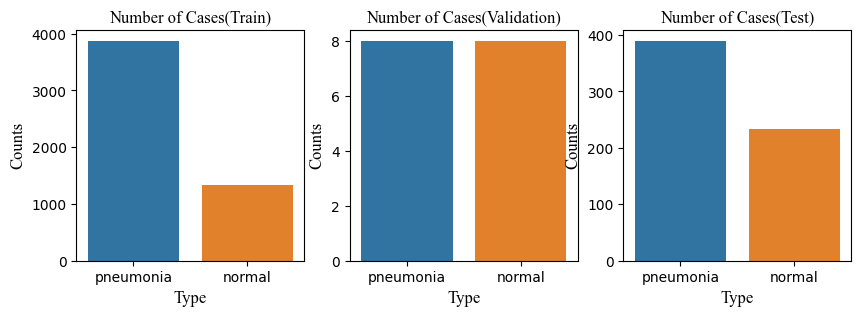

In [30]:
#Show the plot of Counts
classes = removeDs(os.listdir(train_dir))

class_count = len(classes)
print('%s%s%s%s' % ('-'*50, 'Number of Class is:', class_count, '-'*50))


xlabel = 'Type'
ylabel = 'Counts'
fig_size = (10, 3)
title_fontsize = 12
label_fontsize = 12
title = 'Number of Cases'

plt.figure(figsize=fig_size)
count_barplot(train_dir, title=title+'(Train)', xlabel=xlabel,
              ylabel=ylabel, label_fontsize=label_fontsize, sub_no=(131))
count_barplot(validation_dir, title=title+'(Validation)', xlabel=xlabel,
              ylabel=ylabel, figsize=fig_size, label_fontsize=label_fontsize, sub_no=(132))
count_barplot(test_dir, title=title+'(Test)', xlabel=xlabel, ylabel=ylabel,
              figsize=fig_size, label_fontsize=label_fontsize, sub_no=(133))
plt.show()


### Show Samples images

-------------------------------------------------- PNEUMONIA --------------------------------------------------


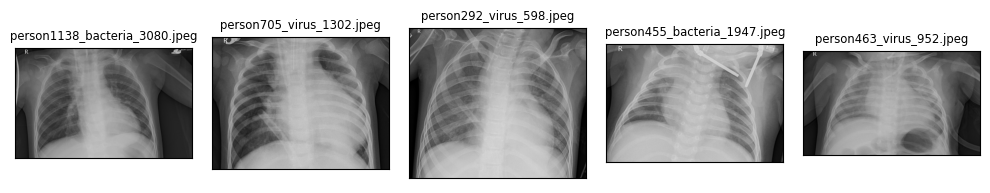


-------------------------------------------------- NORMAL --------------------------------------------------


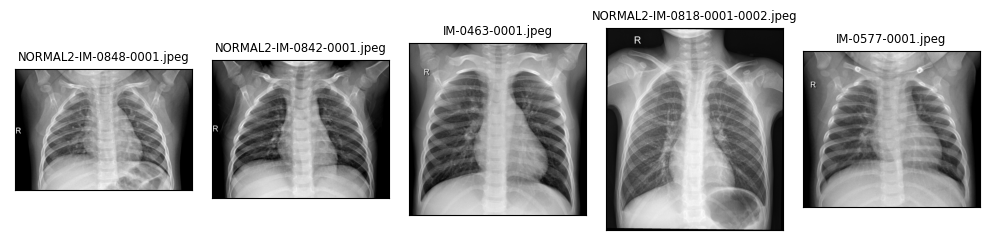


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [171]:
selected_image_show(train_dir, class_count=class_count, count_per_class=5)

### Image Preprocessing

In [28]:
#get all the data arrays
X_train, y_train = get_img_data(train_dir)
X_test, y_test = get_img_data(test_dir)
X_val, y_val = get_img_data(validation_dir)


In [198]:
#resize them

X_train = trans_input_data(X_train, img_size)
X_test = trans_input_data(X_test, img_size)
X_val = trans_input_data(X_val, img_size)


In [199]:
# produce training data input
datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.2, width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True, vertical_flip=False)
datagen.fit(X_train)


In [92]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
callbacks = [learning_rate_reduction]

In [98]:
# Create a model
model_base = get_base_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

### Model training

In [340]:
batch_size = 32
epochs =10
history=fit_model(model_base,callbacks=callbacks,epochs=epochs,batch_size=batch_size)

Epoch 1/10
163/163 [==============================] - 51s 309ms/step - loss: 1.6866 - accuracy: 0.7339 - val_loss: 10.4723 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 51s 313ms/step - loss: 0.5366 - accuracy: 0.7713 - val_loss: 25.6881 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 49s 303ms/step - loss: 0.4786 - accuracy: 0.8313 - val_loss: 4.4548 - val_accuracy: 0.6314 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 49s 302ms/step - loss: 0.4322 - accuracy: 0.8255 - val_loss: 29.5787 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.8321
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 50s 304ms/step - loss: 0.4325 - accuracy: 0.8321 - val_loss: 62.3827 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/10
163/163 [=========================

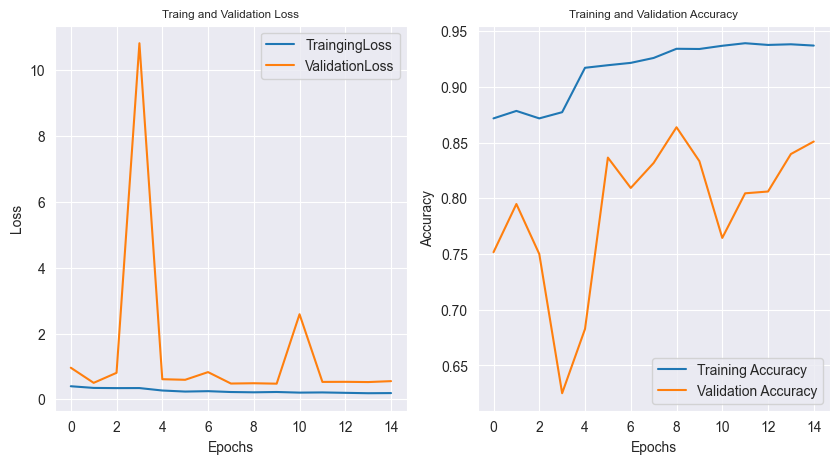

In [388]:
#plot loss and accuracy curve
plot_history(history)

Uderfitting

In [389]:
# show prediction of test dataset
show_predictions(model_base,X_val,y_val)

1/1 [==============================] - 0s 62ms/step - loss: 4.7673 - accuracy: 0.5625
Loss     : 4.77  
Accuracy : 56.25%
**************************************************
Confusion_Matrix:
1/1 [==============================] - 0s 46ms/step
[[8 0]
 [7 1]]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [344]:
# change the batch_size and epochs
batch_size = 64
epochs =15
history=fit_model(model_base,callbacks=callbacks,epochs=epochs,batch_size=batch_size)

Epoch 1/15
82/82 [==============================] - 55s 650ms/step - loss: 0.3982 - accuracy: 0.8717 - val_loss: 0.9612 - val_accuracy: 0.7516 - lr: 0.0010
Epoch 2/15
82/82 [==============================] - 54s 652ms/step - loss: 0.3473 - accuracy: 0.8785 - val_loss: 0.5012 - val_accuracy: 0.7949 - lr: 0.0010
Epoch 3/15
82/82 [==============================] - 56s 690ms/step - loss: 0.3413 - accuracy: 0.8717 - val_loss: 0.8060 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/15
82/82 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.8773
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
82/82 [==============================] - 55s 671ms/step - loss: 0.3427 - accuracy: 0.8773 - val_loss: 10.8237 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/15
82/82 [==============================] - 50s 609ms/step - loss: 0.2683 - accuracy: 0.9172 - val_loss: 0.6119 - val_accuracy: 0.6827 - lr: 3.0000e-04
Epoch 6/15
82/82 [==============================] - 50s 

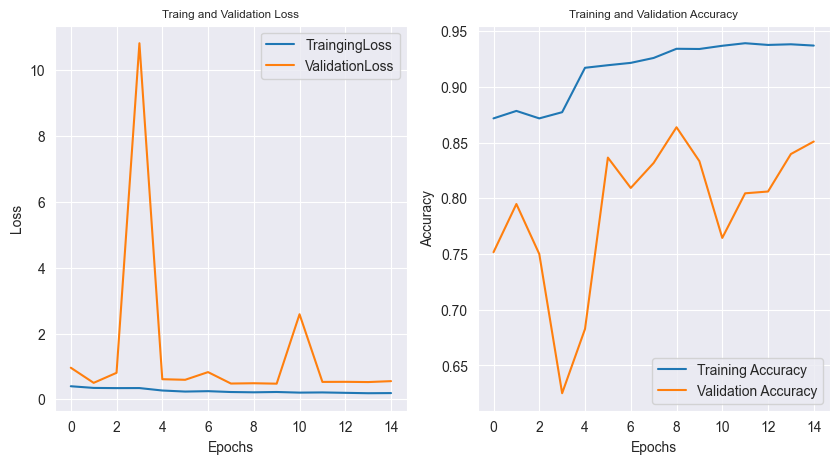

In [345]:
plot_history(history)

In [386]:
show_predictions(model_base,X_val,y_val)

1/1 [==============================] - 0s 166ms/step - loss: 4.7673 - accuracy: 0.5625
Loss     : 4.77  
Accuracy : 56.25%
**************************************************
Confusion_Matrix:
1/1 [==============================] - 0s 103ms/step
[[8 0]
 [7 1]]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [348]:
# train agin with the model which has an extra layer
model = get_base_model_morelayers()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_13 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_14 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_14 (Ba  (None, 75, 75, 64)       

Epoch 1/10
163/163 [==============================] - 65s 390ms/step - loss: 0.2688 - accuracy: 0.9155 - val_loss: 14.7979 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 62s 380ms/step - loss: 0.2129 - accuracy: 0.9237 - val_loss: 9.5352 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 60s 369ms/step - loss: 0.2218 - accuracy: 0.9302 - val_loss: 2.2408 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 61s 375ms/step - loss: 0.2110 - accuracy: 0.9287 - val_loss: 3.3763 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.9260
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 65s 397ms/step - loss: 0.2031 - accuracy: 0.9260 - val_loss: 11.7988 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/10
163/163 [===========================

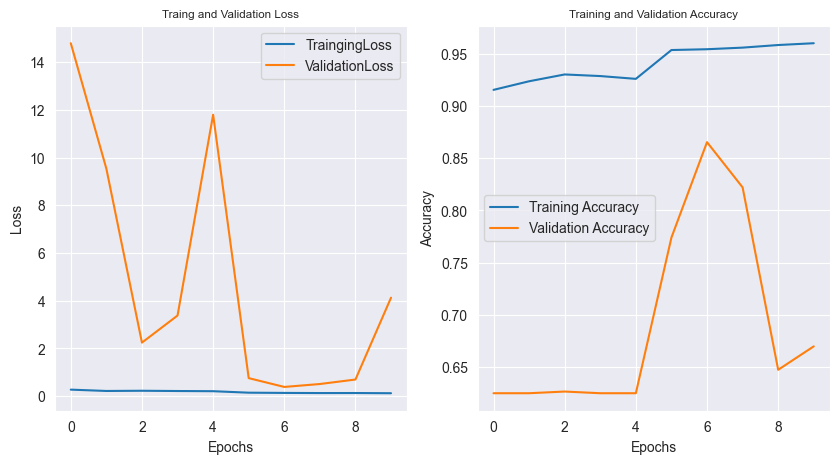

In [387]:
epochs=10
batch_size =32
hist = fit_model(model,epochs = epochs, callbacks=callbacks, batch_size=batch_size)
plot_history(hist)

#underfitting too low value of epochs

Epoch 1/10
82/82 [==============================] - 64s 766ms/step - loss: 0.3703 - accuracy: 0.8990 - val_loss: 29.5156 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/10
82/82 [==============================] - 65s 795ms/step - loss: 0.2711 - accuracy: 0.9116 - val_loss: 4.4287 - val_accuracy: 0.7035 - lr: 0.0010
Epoch 3/10
82/82 [==============================] - 64s 780ms/step - loss: 0.2271 - accuracy: 0.9155 - val_loss: 1.3698 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 4/10
82/82 [==============================] - 63s 762ms/step - loss: 0.2477 - accuracy: 0.9166 - val_loss: 18.4482 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/10
82/82 [==============================] - ETA: 0s - loss: 0.2199 - accuracy: 0.9248
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
82/82 [==============================] - 62s 756ms/step - loss: 0.2199 - accuracy: 0.9248 - val_loss: 57.0479 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/10
82/82 [==============================] - 62s 75

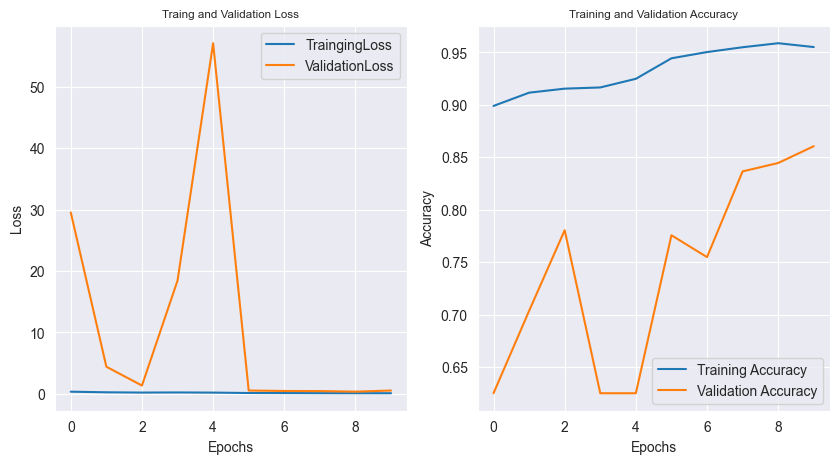

In [351]:
# change the batch_size with bigger value
epochs=10
batch_size =64
hist = fit_model(model,epochs = epochs, callbacks=callbacks, batch_size=batch_size)
plot_history(hist)

underfitting, epochs needs bigger value

Epoch 1/30
82/82 [==============================] - 68s 813ms/step - loss: 0.2736 - accuracy: 0.9264 - val_loss: 2.0895 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 2/30
82/82 [==============================] - 69s 837ms/step - loss: 0.2037 - accuracy: 0.9302 - val_loss: 1.9260 - val_accuracy: 0.6603 - lr: 0.0010
Epoch 3/30
82/82 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9342
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
82/82 [==============================] - 63s 771ms/step - loss: 0.1925 - accuracy: 0.9342 - val_loss: 3.6887 - val_accuracy: 0.6538 - lr: 0.0010
Epoch 4/30
82/82 [==============================] - 63s 770ms/step - loss: 0.1542 - accuracy: 0.9486 - val_loss: 0.9790 - val_accuracy: 0.7420 - lr: 3.0000e-04
Epoch 5/30
82/82 [==============================] - 65s 788ms/step - loss: 0.1346 - accuracy: 0.9538 - val_loss: 1.8711 - val_accuracy: 0.6939 - lr: 3.0000e-04
Epoch 6/30
82/82 [==============================] - 6

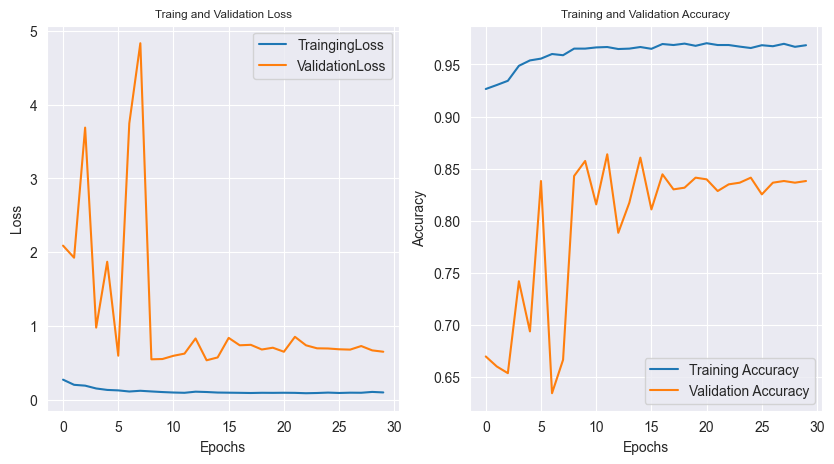

In [352]:
epochs=30
batch_size =64
hist = fit_model(model,epochs = epochs, callbacks=callbacks, batch_size=batch_size)
plot_history(hist)

not perfect but goodfit

### Evaluate the model

In [353]:
# predict with data from the validation folders
pred_y_val = show_predictions(model,X_val,y_val)

1/1 [==============================] - 0s 87ms/step - loss: 0.5247 - accuracy: 0.8125
Loss     : 0.52  
Accuracy : 81.25%
**************************************************
Confusion_Matrix:
1/1 [==============================] - 0s 142ms/step
[[7 1]
 [2 6]]


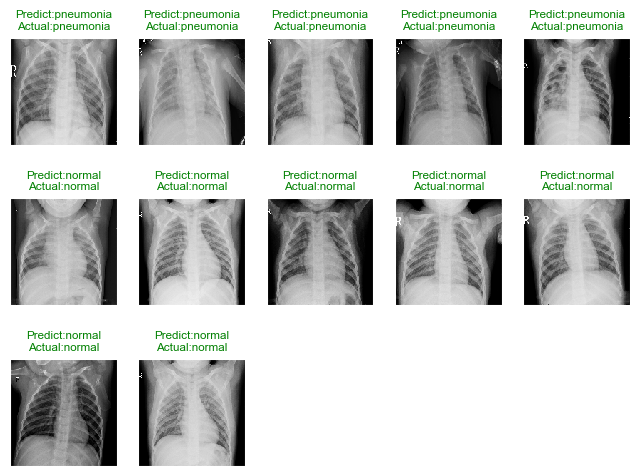

In [354]:
#show all the images which are predicted true
show_correct_img(pred_y_val,X_val,y_val)

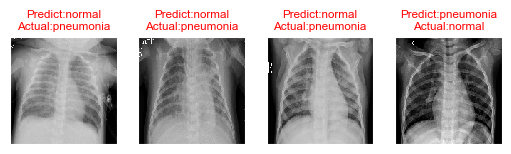

In [355]:
#show all the images which are predicted true
show_fel_img(pred_y_val,X_val,y_val)

In [228]:
#classification report
def classfication_report_plot(y_test,pred_y_test,classes):
    precision = precision_score(y_test,pred_y_test)
    recall = recall_score(y_test,pred_y_test)
    f1 = f1_score(y_test,pred_y_test)

    print('-'*80)
    print('Derived Report')
    print('-'*80)
    print('Precision    :  {:.4} % \nRecall    :  {:.4} % \nF1-Score    :  {:.4} % '.format(precision*100,recall*100,f1*100))
    print('-'*80)
    print('\n')

    cm = confusion_matrix(y_test,pred_y_test)
    print('-'*30,'Confusion Matrix for model','-'*30)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
    #disp.plot(cmap='Blues')
    disp.plot()
    plt.show()

    cls_report = classification_report(y_test,pred_y_test,target_names=classes)
    print('\n')
    print('-'*80)
    print(cls_report)
    print('-'*80)

--------------------------------------------------------------------------------
Derived Report
--------------------------------------------------------------------------------
Precision    :  70.0 % 
Recall    :  87.5 % 
F1-Score    :  77.78 % 
--------------------------------------------------------------------------------


------------------------------ Confusion Matrix for model ------------------------------


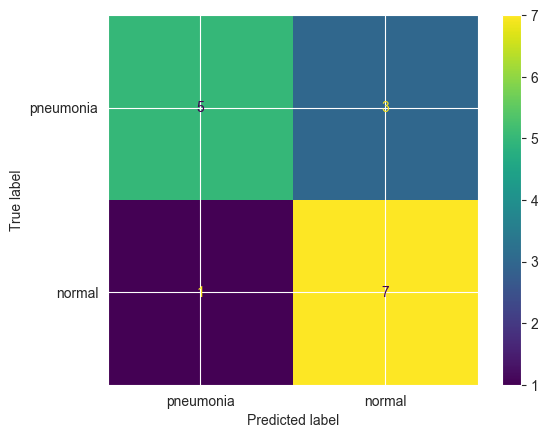



--------------------------------------------------------------------------------
              precision    recall  f1-score   support

   pneumonia       0.83      0.62      0.71         8
      normal       0.70      0.88      0.78         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16

--------------------------------------------------------------------------------


In [383]:
classfication_report_plot(y_val,pred_y_val,classes)

### Compare the model which is trained with 'val'directory as validation dataset, and 'test' as test dataset

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_20 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_23 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_21 (Ba  (None, 75, 75, 64)       

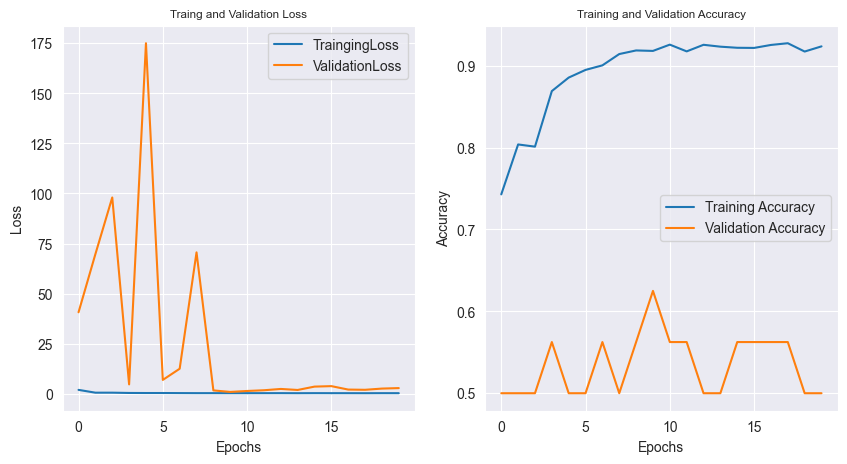

In [392]:
model_base_val=get_base_model()
batch_size = 32
epochs =20
history=fit_model_val(model_base_val,callbacks=callbacks,epochs=epochs,batch_size=batch_size)
print('\n\n')
print('-'*80)
plot_history(history)

Too few validation data affects the performance and the model is much worse than the previous ones

In [396]:
pred_y_test = show_predictions(model_base_val,X_test,y_test)

20/20 [==============================] - 1s 65ms/step - loss: 0.3746 - accuracy: 0.8670
Loss     : 0.37  
Accuracy : 86.70%
**************************************************
Confusion_Matrix:
20/20 [==============================] - 1s 64ms/step
[[339  51]
 [ 32 202]]


In [ ]:
# -------------------------other version---------------------#


## Adjust the test and validation folders to train new models

### Adjust the counts of validation and test datasat

In [133]:
#create a new dataset to train and Copy all the data to the new directory
if os.path.exists(adjust_dir):
    try:
        shutil.rmtree(adjust_dir)       
    except:
        print("Couldn't remove the directory ",adjust_dir)

try: 
    shutil.copytree(input_dir,adjust_dir)
except:
    print("Couldn't copy the directory ",adjust_dir)
    


In [126]:

# Copy the data to the new directory

print(os.listdir(adjust_dir))

['.DS_Store', 'test', 'train', 'val']


In [134]:
test_dir = adjust_dir + '/test'
val_dir = adjust_dir+'/val'
train_dir= adjust_dir +'/'+'train'

In [135]:
counts_in_dataset(adjust_dir)

Count of pneumonia in test dataset is: 390 
Count of normal in test dataset is: 234 
Count of pneumonia in train dataset is: 3875 
Count of normal in train dataset is: 1341 
Count of pneumonia in val dataset is: 8 
Count of normal in val dataset is: 8 


In [136]:
normal_count= len(os.listdir(val_dir+'/'+'normal')) + len(os.listdir(test_dir + '/' +'normal'))
normal_count_mean = normal_count//2
mov_counts_from_test = len(os.listdir(test_dir+'/'+'normal'))-normal_count_mean

In [137]:
# move 113 image files from test data folder to validation folder
print(mov_counts_from_test)

113


In [ ]:
## adjust the dataset numbers
## move some random samples from test dataset to validation dataset

In [138]:
mov_files_from_test.keys()

dict_keys(['pneumonia', 'normal'])

In [139]:
# Randomly select 113files to move,from normal cases and pneumonia cases respectively
src_move_dir = test_dir
des_move_dir = val_dir
mov_files_from_test = select_image_samples(src_move_dir,mov_counts_from_test)

for key in mov_files_from_test:
    for file in mov_files_from_test[key]:
        shutil.move(file,des_move_dir+'/'+key)


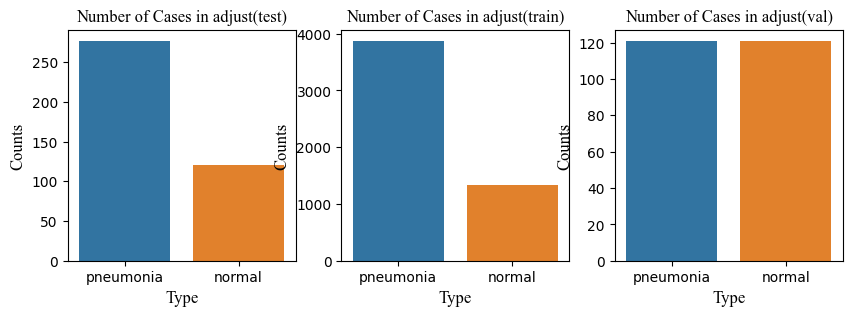

In [140]:
# now ,the new validation and test dataset, to get the same pneumonia and normal cases to test the model
dataset_counts_barplot(adjust_dir)

In [141]:
counts_in_dataset(adjust_dir)

Count of pneumonia in test dataset is: 277 
Count of normal in test dataset is: 121 
Count of pneumonia in train dataset is: 3875 
Count of normal in train dataset is: 1341 
Count of pneumonia in val dataset is: 121 
Count of normal in val dataset is: 121 


In [160]:
#get all the data arrays
X_train, y_train = get_img_data(train_dir)
X_test, y_test = get_img_data(test_dir)
X_val, y_val = get_img_data(val_dir)


In [161]:
#resize them

X_train = trans_input_data(X_train, img_size)
X_test = trans_input_data(X_test, img_size)
X_val = trans_input_data(X_val, img_size)


In [187]:
# produce training data input
datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.2, width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True, vertical_flip=False)
datagen.fit(X_train)
train_dataset = datagen.flow(X_train,y_train,batch_size=batch_size)


In [167]:
# create and train the base model with the fit-parameter 'optimizer' is 'Rmsprop'
model_base = get_base_model()
batch_size = 64
epochs =30
history=fit_model_val(model_base,callbacks=callbacks,epochs=epochs,batch_size=batch_size)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_12 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_16 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_13 (Ba  (None, 75, 75, 64)       

In [168]:
model = get_base_model_morelayers()

batch_size = 64
epochs =30
hist=fit_model_val(model,callbacks=callbacks,epochs=epochs,batch_size=batch_size)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_15 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_20 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_16 (Ba  (None, 75, 75, 64)       

From the accuracy from training and validation, the model is not good, even worse, because the validation dataset reduced . Some data are moved from validation to test folder

------------------------------------------Change the optimizer parameter and model create parameters--------------------------

In [182]:
test_dir = adjust_dir + '/test'
val_dir = adjust_dir+'/val'
train_dir= adjust_dir +'/'+'train'


### Create new model and the adjusted dataset

In [185]:
# It seems more easier to generate batches of image data with data augmentation by using folders directly
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    val_dir, target_size=(150, 150),
    class_mode='categorical',
    batch_size=files_count(val_dir),
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150),
    class_mode='categorical',
    batch_size=files_count(test_dir),
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 242 images belonging to 2 classes.
Found 398 images belonging to 2 classes.


#### Some functions which used to create, train and show the test result of the model

In [ ]:
def get_conv_model():
    model = Sequential()
    # CNN
    model.add(Conv2D(16,  (3, 3), activation='relu', padding='same', input_shape=(150, 150,3)))
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu',padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(
        2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), dilation_rate=(
        2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))

    print(model.summary)

    return model


In [288]:
def show_pred_img_samples(y_test,pred_y_test,cols,rows):
    counts = cols*rows
    filepaths = test_generator.filepaths
    plt.figure(figsize=(10,8))
    plt.rcParams.update({'axes.titlesize': 'small'})
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    i=0
    for count in random.sample(range(len(filepaths)),counts):
        plt.subplot(rows,cols,i+1)
        img_sample = cv2.imread(filepaths[count],1)
        plt.imshow(img_sample,cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if y_test[count]==pred_y_test[count]:
            plt.title('Predict:{}\nActual:{}'.format(classes[pred_y_test[count]],classes[y_test[count]]),fontdict={'color':'green'})
        else:
            plt.title('Predict:{}\nActual:{}'.format(classes[pred_y_test[count]],classes[y_test[count]]),fontdict={'color':'red'})
        i+=1
    


In [196]:
def fit_model_val_cate(model,epochs,callbacks,batch_size):
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(train_generator,batch_size=batch_size,
                        epochs=epochs,validation_data=validation_generator,callbacks=callbacks)
    return history

#### Train the model

In [198]:
model = get_conv_model()
batch_size = 64
epochs =30
history=fit_model_val_cate(model,callbacks=callbacks,epochs=epochs,batch_size=batch_size)

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x17eebd600>>
Epoch 1/30
163/163 [==============================] - 52s 313ms/step - loss: 0.5799 - accuracy: 0.7414 - val_loss: 0.7204 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 51s 312ms/step - loss: 0.4848 - accuracy: 0.7820 - val_loss: 0.8057 - val_accuracy: 0.5413 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - 51s 311ms/step - loss: 0.4028 - accuracy: 0.8250 - val_loss: 0.6352 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 51s 310ms/step - loss: 0.3553 - accuracy: 0.8526 - val_loss: 0.7779 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 5/30
163/163 [==============================] - 52s 315ms/step - loss: 0.2467 - accuracy: 0.9018 - val_loss: 0.3955 - val_accuracy: 0.8512 - lr: 0.0010
Epoch 6/30
163/163 [==============================] - 51s 312ms/step - loss: 0.2032 - accuracy: 0.9245 - val_loss: 

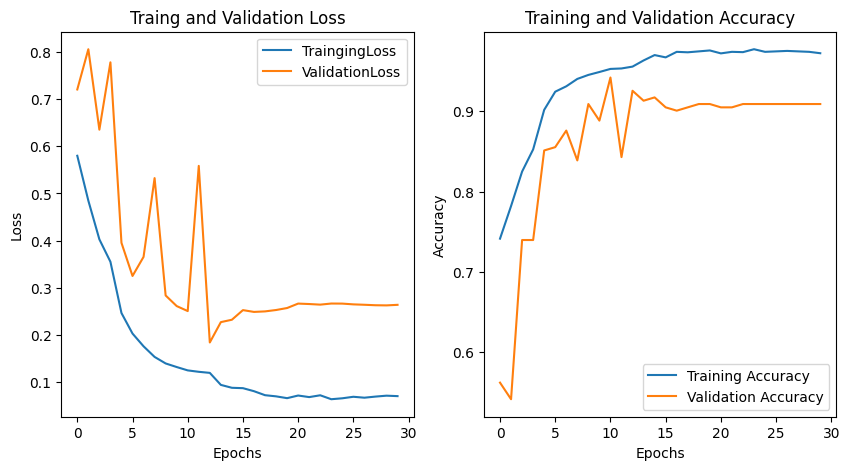

In [199]:
plot_history(history)

Much better! 

#### Evaluate and classfication report

In [200]:
print('Test Result:')
result = model.evaluate_generator(test_generator,steps=len(test_generator),verbose=1)
print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

Test Result:


/var/folders/3d/_ykwgmh97v144k3yyhms0wyr0000gn/T/ipykernel_1258/3616738980.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result = model.evaluate_generator(test_generator,steps=len(test_generator),verbose=1)


1/1 [==============================] - 2s 2s/step - loss: 0.1982 - accuracy: 0.9347
Loss     : 0.20  
Accuracy : 93.47%


In [201]:

pred_y_test = model.predict_generator(test_generator,steps=len(test_generator),verbose=1)
pred_y_test = pred_y_test.argmax(axis =-1)
y_test = test_generator.classes

/var/folders/3d/_ykwgmh97v144k3yyhms0wyr0000gn/T/ipykernel_1258/3955645718.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_y_test = model.predict_generator(test_generator,steps=len(test_generator),verbose=1)


1/1 [==============================] - 2s 2s/step


In [248]:
classes = removeDs(os.listdir(train_dir))
classes.sort()
print(classes)

['normal', 'pneumonia']


--------------------------------------------------------------------------------
Derived Report
--------------------------------------------------------------------------------
Precision    :  92.26 % 
Recall    :  98.92 % 
F1-Score    :  95.47 % 
--------------------------------------------------------------------------------


------------------------------ Confusion Matrix for model ------------------------------


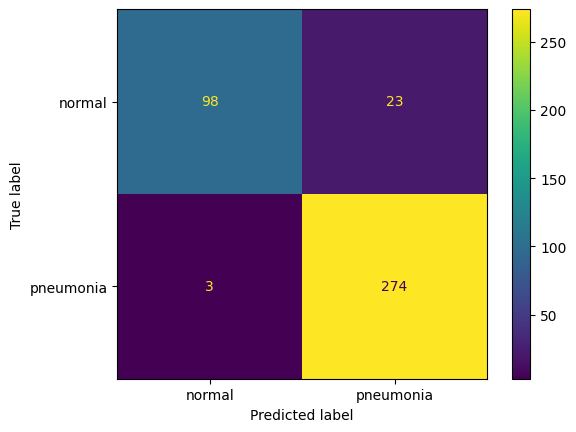



--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      normal       0.97      0.81      0.88       121
   pneumonia       0.92      0.99      0.95       277

    accuracy                           0.93       398
   macro avg       0.95      0.90      0.92       398
weighted avg       0.94      0.93      0.93       398

--------------------------------------------------------------------------------


In [249]:
classfication_report_plot(y_test=y_test,pred_y_test=pred_y_test,classes=classes)

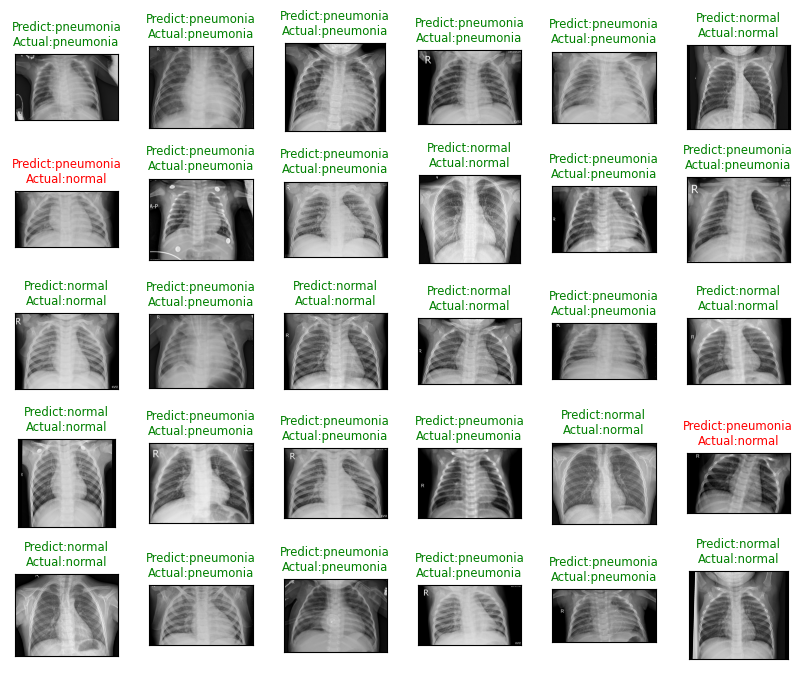

In [ ]:
# show some predicted cases randomly
show_pred_img_samples(y_test,pred_y_test,6,5)

## Summery

1. There are many parameters and methods to help us to build a good CNN model. Some are important and have strong impact on performance
   - Optimizer 'Adam' is better than 'rmsprop'
   - Some model need appropriate value, too small value leads to underfitting
   - Batch_size can change the performance

2. The structure of the dataset, and the proportion of dataset (size) is very important for model training. Validition data size can not be too small,otherwize it leads the worse performance. Also,with too small test dataset size, the test result can not be really revealed.